Using model: D:\Sync\DL_Development\Models\DL_model_2022_07_25_11_15_55.model
             r2  rmse   mape
wood       0.88  2.29  0.581
bark       0.76  0.41  0.761
branch     0.74  0.61  0.813
foliage    0.65  0.35  0.705
total_agb  0.88  3.09  0.555


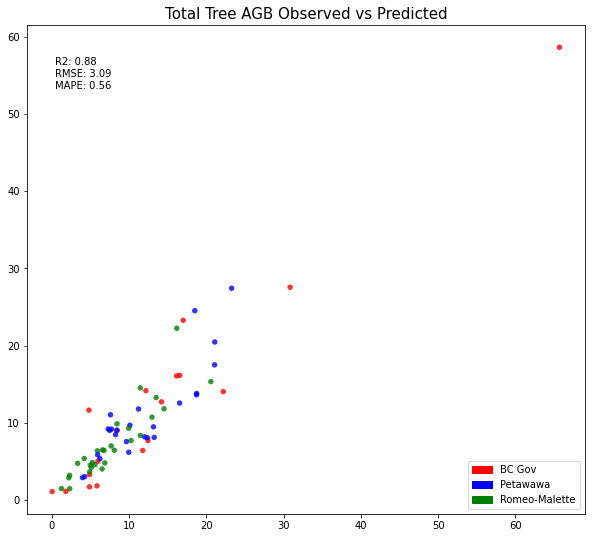

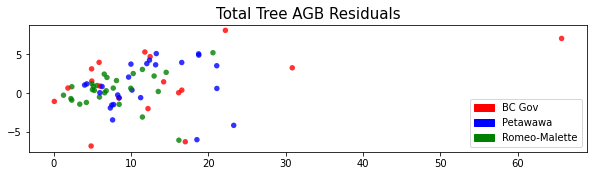

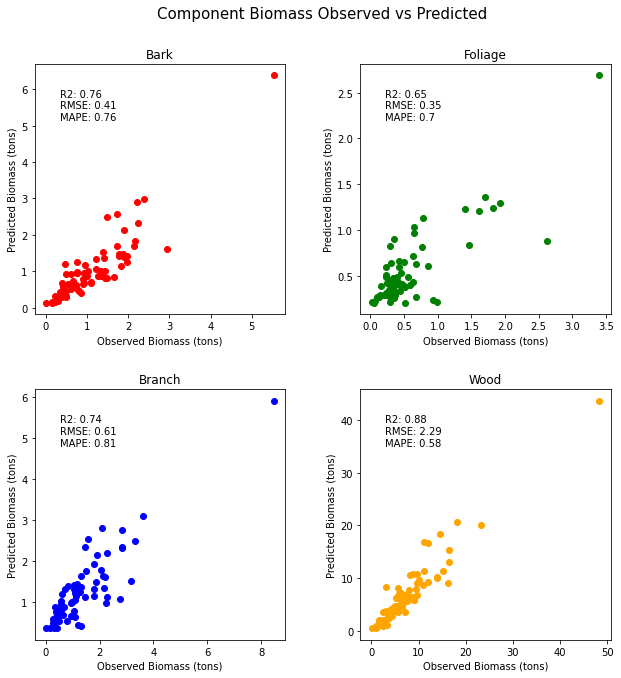

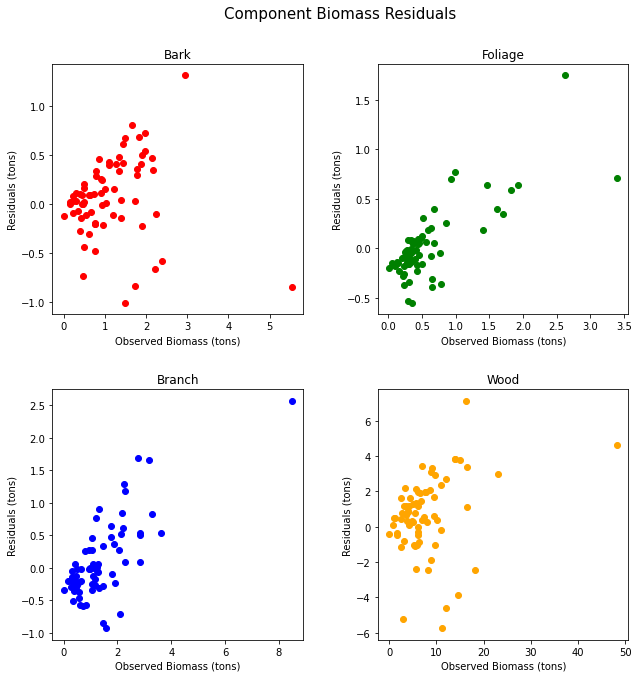

In [82]:
import os.path
import glob
import torch
from torch_geometric.loader import DataLoader
from pointcloud_dataloader import PointCloudsInFiles
from matplotlib import pyplot as plt
import sklearn.metrics as metrics
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches


# Apply the model to the test dataset and plot the results --------------------------------------------------

# Select a model to use:
model_file = None

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Specify model params
use_columns = ['intensity_normalized']
use_datasets = ["BC", "RM", "PF"]  # Possible datasets: BC, RM, PF
num_points = 7_000
test_dataset_path = r'D:\Sync\Data\Model_Input\test'

# Load most recent model
if model_file is None:
    folder_path = r'D:\Sync\DL_Development\Models'
    file_type = r'\*.model'
    files = glob.glob(folder_path + file_type)
    model_file = max(files, key=os.path.getctime)
    model = torch.load(model_file)
else:
    model = torch.load(model_file)
print("Using model:", model_file)

# Get test data
test_dataset = PointCloudsInFiles(test_dataset_path, '*.las', max_points=num_points, use_columns=use_columns,
                                  filter_height=0.2, dataset=use_datasets)

test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, num_workers=0)

# Apply the model to test data --------------------------------------------------------------------------
model.eval()
for idx, data in enumerate(test_loader):
    data = data.to(device)
    pred = torch.reshape(model(data), (len(data.y), 1)).to('cpu').detach().numpy()
    obs = torch.reshape(data.y, (len(data.y), 1)).to('cpu').detach().numpy()
    PlotID = data.PlotID

#Reshape for bark, branch, foliage, wood columns
obs_arr = np.reshape(a=obs, newshape=(len(obs)//4, 4))
pred_arr = np.reshape(a=pred, newshape=(len(obs)//4, 4))
#Join arrays
arr = arr = np.concatenate((obs_arr, pred_arr), axis=1)
#Convert to data frame
df = pd.DataFrame(arr,
             columns=['bark_obs', 'branch_obs', 'foliage_obs', 'wood_obs',
                      'bark_pred', 'branch_pred', 'foliage_pred', 'wood_pred'],
                  index=PlotID)

#Add observed/predicted total biomass columns to df
df["total_agb_obs"] = df["bark_obs"] + df["branch_obs"] + df["foliage_obs"] + df["wood_obs"]
df["total_agb_pred"] = df["bark_pred"] + df["branch_pred"] + df["foliage_pred"] + df["wood_pred"]

#Get residuals
df["total_agb_resid"] = df["total_agb_obs"] - df["total_agb_pred"]
df["bark_resid"] = df["bark_obs"] - df["bark_pred"]
df["branch_resid"] = df["branch_obs"] - df["branch_pred"]
df["foliage_resid"] = df["foliage_obs"] - df["foliage_pred"]
df["wood_resid"] = df["wood_obs"] - df["wood_pred"]

# Calculate test metrics for each component -------------------------------------------------------------

#Create a data frame to store component metrics
metrics_df = pd.DataFrame(columns=["r2", "rmse", "mape"], index= ["wood", "bark", "branch", "foliage", "total_agb"])

#Loop through each biomass component get model performance metrics
for comp in metrics_df.index.tolist():
    metrics_df.loc[comp, "r2"] = round(metrics.r2_score(df[f"{comp}_obs"], df[f"{comp}_pred"]), 2)
    metrics_df.loc[comp, "rmse"] = round(sqrt(metrics.mean_squared_error(df[f"{comp}_obs"], df[f"{comp}_pred"])), 2)
    metrics_df.loc[comp, "mape"] = round(metrics.mean_absolute_percentage_error(df[f"{comp}_obs"], df[f"{comp}_pred"]), 3)

print(metrics_df)

#Plot total AGB biomass obs. vs. predicted, and residuals -----------------------------------------------

#Add dataset col
df["dataset"] = "blank"

#Add a column to df for dataset
for id in  df.index.tolist():
    df.loc[id, "dataset"] = id[0:2]

#Add color for each dataset
df["colour"] = "green"
df.loc[df["dataset"] == "BC", "colour"] = "red"
df.loc[df["dataset"] == "PF", "colour"] = "blue"

# Create plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df["total_agb_obs"], df["total_agb_pred"],
           alpha=0.8, c=df["colour"], edgecolors='none', s=30,
           label=df["dataset"])

plt.figtext(0.05, 0.9, f"R2: {metrics_df.loc['total_agb', 'r2']}\nRMSE: {metrics_df.loc['total_agb', 'rmse']}\nMAPE: {str(round(metrics_df.loc['total_agb', 'mape'], 2))}",
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes)

#Add legend
red_patch = mpatches.Patch(color="red", label='BC Gov')
blue_patch = mpatches.Patch(color="blue", label='Petawawa')
green_patch = mpatches.Patch(color="green", label='Romeo-Malette')
plt.legend(handles=[red_patch, blue_patch, green_patch], loc='lower right')

#Add title
plt.title("Total Tree AGB Observed vs Predicted", fontdict=None, loc='center', fontsize=15)

#Set axis so its scaled properly
plt.axis('scaled')

plt.show()

#Make plot for total AGB residuals
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df["total_agb_obs"], df["total_agb_resid"],
           alpha=0.8, c=df["colour"], edgecolors='none', s=30,
           label=df["dataset"])
#Add legend
red_patch = mpatches.Patch(color="red", label='BC Gov')
blue_patch = mpatches.Patch(color="blue", label='Petawawa')
green_patch = mpatches.Patch(color="green", label='Romeo-Malette')
plt.legend(handles=[red_patch, blue_patch, green_patch], loc='lower right')

#Add title
plt.title("Total Tree AGB Residuals", fontdict=None, loc='center', fontsize=15)

#Set axis so its scaled properly
plt.axis('scaled')

plt.show()


#Plot biomass component obs. vs. predicted, and residuals -----------------------------------------------
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Add the main title
fig.suptitle("Component Biomass Observed vs Predicted", fontsize=15)

#Bark
ax[0, 0].scatter(df["bark_obs"], df["bark_pred"], color="red")

#Branch
ax[1, 0].scatter(df["branch_obs"], df["branch_pred"], color="blue")

#Foliage
ax[0, 1].scatter(df["foliage_obs"], df["foliage_pred"], color="green")

#Wood
ax[1, 1].scatter(df["wood_obs"], df["wood_pred"], color="orange")

#Add titles
ax[0, 0].title.set_text('Bark')
ax[1, 0].title.set_text('Branch')
ax[0, 1].title.set_text('Foliage')
ax[1, 1].title.set_text('Wood')

# Add summary stats text
ax[0, 0].text(0.1, 0.9, f"R2: {metrics_df.loc['bark', 'r2']}\nRMSE: {metrics_df.loc['bark', 'rmse']}\nMAPE: {str(round(metrics_df.loc['bark', 'mape'], 2))}",
              horizontalalignment='left', verticalalignment='top', transform=ax[0, 0].transAxes)
ax[1, 0].text(0.1, 0.9, f"R2: {metrics_df.loc['branch', 'r2']}\nRMSE: {metrics_df.loc['branch', 'rmse']}\nMAPE: {str(round(metrics_df.loc['branch', 'mape'], 2))}",
              horizontalalignment='left', verticalalignment='top', transform=ax[1, 0].transAxes)
ax[0, 1].text(0.1, 0.9, f"R2: {metrics_df.loc['foliage', 'r2']}\nRMSE: {metrics_df.loc['foliage', 'rmse']}\nMAPE: {str(round(metrics_df.loc['foliage', 'mape'], 2))}",
              horizontalalignment='left', verticalalignment='top', transform=ax[0, 1].transAxes)
ax[1, 1].text(0.1, 0.9, f"R2: {metrics_df.loc['wood', 'r2']}\nRMSE: {metrics_df.loc['wood', 'rmse']}\nMAPE: {str(round(metrics_df.loc['wood', 'mape'], 2))}",
              horizontalalignment='left', verticalalignment='top', transform=ax[1, 1].transAxes)

#Add axis labels
for axis in ax.flat:
    axis.set(xlabel='Observed Biomass (tons)', ylabel='Predicted Biomass (tons)')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.3)

plt.show()

#Make plots for component residuals
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Add the main title
fig.suptitle("Component Biomass Residuals", fontsize=15)

#Bark
ax[0, 0].scatter(df["bark_obs"], df["bark_resid"], color="red")
ax[1, 0].scatter(df["branch_obs"], df["branch_resid"], color="blue")
ax[0, 1].scatter(df["foliage_obs"], df["foliage_resid"], color="green")
ax[1, 1].scatter(df["wood_obs"], df["wood_resid"], color="orange")

#Add titles
ax[0, 0].title.set_text('Bark')
ax[1, 0].title.set_text('Branch')
ax[0, 1].title.set_text('Foliage')
ax[1, 1].title.set_text('Wood')

#Add axis labels
for axis in ax.flat:
    axis.set(xlabel='Observed Biomass (tons)', ylabel='Residuals (tons)')

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.3)

plt.show()
